In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
import yfinance as yf

news_raw = pd.read_csv("../data/raw_analyst_ratings.csv")
news_raw.columns


Index(['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock'], dtype='object')

In [40]:
# Standardize column names (make lowercase)
news_raw.columns = news_raw.columns.str.lower()

# Create unified columns: date + headline
news = pd.DataFrame()

# Date column mapping
if "date" in news_raw.columns:
    news["date"] = news_raw["date"]
elif "publishedat" in news_raw.columns:
    news["date"] = news_raw["publishedat"]

# Headline column mapping
if "headline" in news_raw.columns:
    news["headline"] = news_raw["headline"]
elif "title" in news_raw.columns:
    news["headline"] = news_raw["title"]
elif "text" in news_raw.columns:
    news["headline"] = news_raw["text"]

# Optional publisher (if exists)
if "publisher" in news_raw.columns:
    news["publisher"] = news_raw["publisher"]
elif "source" in news_raw.columns:
    news["publisher"] = news_raw["source"]
else:
    news["publisher"] = "Unknown"


In [41]:
news['date'] = pd.to_datetime(news['date'], errors='coerce')
news = news.dropna(subset=['date'])
news = news.dropna(subset=["headline"])
news.to_csv("news_cleaned.csv", index=False)


In [ ]:
news = pd.read_csv("../data/news_cleaned.csv")
news['date'] = pd.to_datetime(news['date'])
news.head()

,date,headline,publisher
0,2020-06-05 10:30:54-04:00,Stocks That Hit 52-Week Highs On Friday,Benzinga Insights
1,2020-06-03 10:45:20-04:00,Stocks That Hit 52-Week Highs On Wednesday,Benzinga Insights
2,2020-05-26 04:30:07-04:00,71 Biggest Movers From Friday,Lisa Levin
3,2020-05-22 12:45:06-04:00,46 Stocks Moving In Friday's Mid-Day Session,Lisa Levin
4,2020-05-22 11:38:59-04:00,B of A Securities Maintains Neutral on Agilent...,Vick Meyer


Load Stock Price Data

In [48]:
stock = yf.download("AAPL", start="2010-01-01", end="2025-01-01")
stock.reset_index(inplace=True)
stock['Date'] = pd.to_datetime(stock['Date'])
stock.head()


C:\Users\PC\AppData\Local\Temp\ipykernel_12060\2606595015.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download("AAPL", start="2010-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL
0,2010-01-04,6.418384,6.433080,6.369499,6.400989,493729600
1,2010-01-05,6.429481,6.465770,6.395591,6.436079,601904800
2,2010-01-06,6.327210,6.454972,6.320612,6.429479,552160000
3,2010-01-07,6.315514,6.358101,6.269627,6.350604,477131200
4,2010-01-08,6.357502,6.358102,6.269929,6.307117,447610800


Sentiment Analysis

In [49]:
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

news['sentiment'] = news['headline'].apply(get_sentiment)


Compute Daily Average Sentiment

In [50]:
# FIX daily_sentiment
daily_sentiment = daily_sentiment.copy()
if isinstance(daily_sentiment.index, pd.MultiIndex):
    daily_sentiment = daily_sentiment.reset_index(drop=True)

daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date']).dt.date
print(daily_sentiment.head())

# FIX daily_returns
daily_returns = daily_returns.copy()
daily_returns.columns = [col[0] if isinstance(col, tuple) else col for col in daily_returns.columns]
if isinstance(daily_returns.index, pd.MultiIndex):
    daily_returns = daily_returns.reset_index(drop=True)

daily_returns['date'] = pd.to_datetime(daily_returns['date'])
print(daily_returns.head())

# MERGE
combined = pd.merge(
    daily_sentiment,
    daily_returns,
    on='date',
    how='inner'
)
combined.head()



         date  sentiment
0  2011-04-27   0.000000
1  2011-04-28   0.136364
2  2011-04-28   0.000000
3  2011-04-29  -0.166667
4  2011-04-29   0.500000
Empty DataFrame
Columns: [date, Daily_Return]
Index: []


,date,sentiment,Daily_Return


In [51]:
correlation = combined['sentiment'].corr(combined['Daily_Return'])
correlation
print(f"Correlation between sentiment and daily returns: {correlation}")

Correlation between sentiment and daily returns: nan


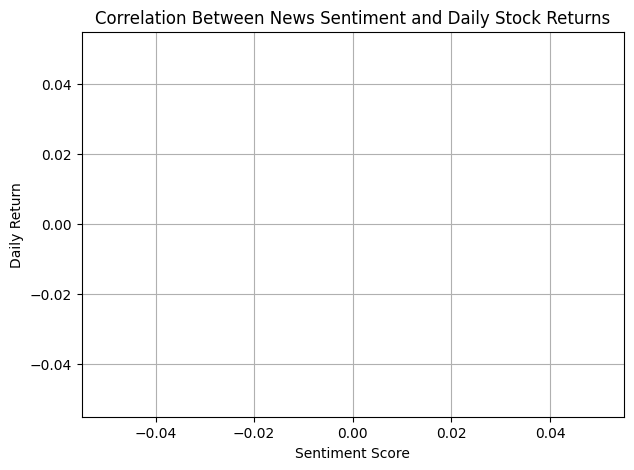

In [47]:
plt.figure(figsize=(7,5))
plt.scatter(combined['sentiment'], combined['Daily_Return'])
plt.title("Correlation Between News Sentiment and Daily Stock Returns")
plt.xlabel("Sentiment Score")
plt.ylabel("Daily Return")
plt.grid(True)
plt.show()
